<a href="https://colab.research.google.com/github/jithendra1798/ML-CS-GY-6923-B/blob/main/09_ml_cs_gy_6923_b_lab_06_rnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: RNNs

## Part 1: Manual RNN

In this first part of the lab, you will need to implement the components of the RNN manually and check your implementation against pytorch. The goal is to get a good low-level understanding of what an RNN is actually doing.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

First, complete the implementation of the embedding layer below.

In [ ]:
class ManualEmbedding(nn.Module):
    """
    Manual implementation of an embedding layer.

    An embedding layer is essentially a lookup table that maps integer indices
    to dense vectors. Mathematically, it's equivalent to one-hot encoding
    followed by a matrix multiplication.

    Args:
        vocab_size: Number of unique tokens in vocabulary
        embed_dim: Dimension of embedding vectors
    """
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.weight = nn.Parameter(torch.randn(vocab_size, embed_dim))

    def forward(self, x):
        """
        Args:
            x: Integer tensor of shape (batch_size, seq_length)

        Returns:
            embedded: Tensor of shape (batch_size, seq_length, embed_dim)

        TODO: Implement the forward pass
        Hint: You can use indexing (self.weight[x]) or torch.index_select
        """
        # Your implementation here
        embedded = self.weight[x]
        return embedded

Next, complete the implementation of an RNN cell below. The cell is a single transition in an RNN, see docstring for details.

In [ ]:
class ManualRNNCell(nn.Module):
    """
    Manual implementation of a single RNN cell.

    A vanilla RNN cell computes:
        h_t = tanh(W_ih @ x_t + b_ih + W_hh @ h_{t-1} + b_hh)

    where:
        x_t is the input at time t
        h_t is the hidden state at time t
        W_ih is the input-to-hidden weight matrix
        W_hh is the hidden-to-hidden weight matrix
        b_ih, b_hh are bias vectors

    Args:
        input_size: Dimension of input features
        hidden_size: Dimension of hidden state
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W_ih = nn.Parameter(torch.randn(hidden_size, input_size))
        self.b_ih = nn.Parameter(torch.randn(hidden_size))
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_hh = nn.Parameter(torch.randn(hidden_size))

        # Initialize weights (Xavier initialization)
        nn.init.xavier_uniform_(self.W_ih)
        nn.init.xavier_uniform_(self.W_hh)
        nn.init.zeros_(self.b_ih)
        nn.init.zeros_(self.b_hh)

    def forward(self, x, hidden):
        """
        Args:
            x: Input tensor of shape (batch_size, input_size)
            hidden: Previous hidden state of shape (batch_size, hidden_size)

        Returns:
            new_hidden: New hidden state of shape (batch_size, hidden_size)

        TODO: Implement the RNN cell computation
        Hint: Use torch.matmul or @ for matrix multiplication
        Hint: Use torch.tanh for activation
        """
        # Your implementation here
        # h_t = tanh(W_ih @ x_t + b_ih + W_hh @ h_{t-1} + b_hh)

        Wx = x @ self.W_ih.T + self.b_ih

        Wh = hidden @ self.W_hh.T + self.b_hh

        new_hidden = torch.tanh(Wx + Wh)
        return new_hidden


Now, we will use our `ManualRNNCell` class to make a full RNN. Complete the code below. Note that the code should work with multiple hidden layers.

In [ ]:
class ManualRNN(nn.Module):
    """
    Manual implementation of a multi-layer RNN.

    This processes a sequence by applying RNN cells across time steps
    and optionally across multiple layers.

    Args:
        input_size: Dimension of input features
        hidden_size: Dimension of hidden state
        num_layers: Number of stacked RNN layers
    """
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList()
        for layer in range(num_layers):
            input_dim = input_size if layer == 0 else hidden_size
            self.cells.append(ManualRNNCell(input_dim, hidden_size))

    def forward(self, x, hidden=None):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size)
            hidden: Initial hidden state of shape (num_layers, batch_size, hidden_size)
                   If None, initialize with zeros

        Returns:
            output: Output tensor of shape (batch_size, seq_length, hidden_size)
            hidden: Final hidden state of shape (num_layers, batch_size, hidden_size)

        TODO: Implement the forward pass
        Hint: Loop over sequence length (time steps)
        Hint: Loop over layers
        Hint: Each layer's output becomes the next layer's input
        """
        batch_size, seq_length, _ = x.shape

        # Initialize hidden state if not provided
        if hidden is None:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size,
                               device=x.device, dtype=x.dtype)

        # Clone hidden state to avoid modifying the input tensor
        hidden = hidden.clone()

        # Store outputs for each time step
        outputs = []

        # Process sequence
        for t in range(seq_length):
            # Get input at time t
            input_t = x[:, t, :]  # (batch_size, input_size)

            # Process through each layer
            for layer_idx in range(self.num_layers):

                # 1. Get hidden state for this layer
                h_prev = hidden[layer_idx]

                # 2. Apply RNN cell
                h_new = self.cells[layer_idx](input_t, h_prev)

                # 3. Update hidden state
                hidden[layer_idx] = h_new

                # 4. Output of this layer becomes input to next layer
                input_t = h_new

            outputs.append(input_t.unsqueeze(1))

        output = torch.cat(outputs, dim=1)  # (batch_size, seq_length, hidden_size)

        return output, hidden

Finally, we can put everything together to make a ful RNN. Run the code and the tests below, and make sure the tests pass.

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=2):
        """
        Character-level RNN for language modeling

        Args:
            vocab_size: Number of unique characters in vocabulary
            embed_dim: Dimension of character embeddings
            hidden_dim: Dimension of RNN hidden state
            num_layers: Number of stacked RNN layers
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Character embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # RNN layer (you can swap with LSTM or GRU)
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,  # Input shape: (batch, seq, feature)
            dropout=0
        )

        # Output layer to predict next character
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_length)
            hidden: Optional hidden state from previous step

        Returns:
            logits: Predicted logits of shape (batch_size, seq_length, vocab_size)
            hidden: Hidden state for next step
        """
        # Embed characters: (batch, seq) -> (batch, seq, embed_dim)
        embedded = self.embedding(x)

        # Pass through RNN: (batch, seq, embed_dim) -> (batch, seq, hidden_dim)
        rnn_out, hidden = self.rnn(embedded, hidden)

        # Project to vocabulary: (batch, seq, hidden_dim) -> (batch, seq, vocab_size)
        logits = self.fc(rnn_out)

        return logits, hidden

    def init_hidden(self, batch_size, device='cpu'):
        """Initialize hidden state with zeros"""
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)


class ManualCharRNN(nn.Module):
    """
    Character-level RNN using manual implementations of all layers.

    This should be functionally equivalent to the standard CharRNN,
    but using your custom Embedding, RNN, and Linear layers.
    """
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # TODO: Use your manual implementations
        self.embedding = ManualEmbedding(vocab_size, embed_dim)
        self.rnn = ManualRNN(embed_dim, hidden_dim, num_layers)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_length)
            hidden: Optional hidden state from previous step

        Returns:
            logits: Predicted logits of shape (batch_size, seq_length, vocab_size)
            hidden: Hidden state for next step
        """
        # TODO: Implement forward pass using your custom layers
        embedded = self.embedding(x)
        rnn_out, hidden = self.rnn(embedded, hidden)
        logits = self.fc(rnn_out)
        return logits, hidden

    def init_hidden(self, batch_size, device='cpu'):
        """Initialize hidden state with zeros"""
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

In [ ]:
def test_embedding():
    """Test the manual embedding layer"""
    print("=" * 70)
    print("Testing Embedding Layer")
    print("=" * 70)

    vocab_size, embed_dim = 10, 8
    batch_size, seq_len = 2, 5

    # Create both versions
    manual_emb = ManualEmbedding(vocab_size, embed_dim)
    pytorch_emb = nn.Embedding(vocab_size, embed_dim)

    # Copy weights to make them identical
    pytorch_emb.weight.data = manual_emb.weight.data.clone()

    # Test input
    x = torch.randint(0, vocab_size, (batch_size, seq_len))

    # Forward pass
    manual_out = manual_emb(x)
    pytorch_out = pytorch_emb(x)
    max_diff = (manual_out - pytorch_out).abs().max().item()

    # Compare
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {manual_out.shape}")
    print(f"Max difference: {max_diff:.10f}")
    if max_diff > 1e-6:
        print(f"✗ Embedding layer test failed!")
    else:
      print(f"✓ Embedding layer test passed!\n")


def test_rnn_cell():
    """Test the manual RNN cell"""
    print("=" * 70)
    print("Testing RNN Cell")
    print("=" * 70)

    input_size, hidden_size = 10, 16
    batch_size = 2

    # Create manual cell
    manual_cell = ManualRNNCell(input_size, hidden_size)
    pytorch_cell = nn.RNNCell(input_size, hidden_size)

    pytorch_cell.weight_hh.data = manual_cell.W_hh.data.clone()
    pytorch_cell.weight_ih.data = manual_cell.W_ih.data.clone()
    pytorch_cell.bias_hh.data = manual_cell.b_hh.data.clone()
    pytorch_cell.bias_ih.data = manual_cell.b_ih.data.clone()

    # Test input
    x = torch.randn(batch_size, input_size)
    h = torch.randn(batch_size, hidden_size)

    # Forward pass
    new_h = manual_cell(x, h)
    new_h_pytorch = pytorch_cell(x, h)
    max_diff = (new_h_pytorch - new_h).abs().max().item()

    # Compare
    print(f"Input shape: {x.shape}")
    print(f"Hidden shape: {h.shape}")
    print(f"Output hidden shape: {new_h.shape}")
    # print(f"Output hidden range: [{new_h.min().item():.3f}, {new_h.max().item():.3f}]")
    print(f"Max difference: {max_diff:.10f}")
    if max_diff > 1e-6:
        print(f"✗ RNN cell test failed!")
    else:
      print(f"✓ RNN cell test passed!\n")


def test_rnn():
    """Test the manual RNN layer"""
    print("=" * 70)
    print("Testing RNN Layer")
    print("=" * 70)

    input_size, hidden_size, num_layers = 10, 16, 2
    batch_size, seq_len = 2, 5

    # Create both versions
    manual_rnn = ManualRNN(input_size, hidden_size, num_layers)
    pytorch_rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    # Copy weights to make them identical
    for layer in range(num_layers):
        # PyTorch RNN uses different parameter names
        pytorch_rnn.__getattr__(f'weight_ih_l{layer}').data = manual_rnn.cells[layer].W_ih.data.clone()
        pytorch_rnn.__getattr__(f'weight_hh_l{layer}').data = manual_rnn.cells[layer].W_hh.data.clone()
        pytorch_rnn.__getattr__(f'bias_ih_l{layer}').data = manual_rnn.cells[layer].b_ih.data.clone()
        pytorch_rnn.__getattr__(f'bias_hh_l{layer}').data = manual_rnn.cells[layer].b_hh.data.clone()

    # Test input
    x = torch.randn(batch_size, seq_len, input_size)
    h = torch.randn(num_layers, batch_size, hidden_size)

    # Forward pass
    manual_out, manual_h = manual_rnn(x, h)
    pytorch_out, pytorch_h = pytorch_rnn(x, h)

    o_max_diff = (manual_out - pytorch_out).abs().max().item()
    h_max_diff = (manual_h - pytorch_h).abs().max().item()

    # Compare
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {manual_out.shape}")
    print(f"Hidden shape: {manual_h.shape}")
    print(f"Output max difference: {o_max_diff:.10f}")
    print(f"Hidden max difference: {h_max_diff:.10f}")
    if o_max_diff > 1e-6 or h_max_diff > 1e-6:
      print(f"✗ RNN layer test failed!")
    else:
      print(f"✓ RNN layer test passed!\n")


def test_full_model():
    """Test the complete CharRNN model"""
    print("=" * 70)
    print("Testing Complete CharRNN Model")
    print("=" * 70)

    vocab_size = 50
    embed_dim, hidden_dim, num_layers = 32, 64, 2
    batch_size, seq_len = 4, 10

    # Create both models
    manual_model = ManualCharRNN(vocab_size, embed_dim, hidden_dim, num_layers)
    pytorch_model = CharRNN(vocab_size, embed_dim, hidden_dim, num_layers)

    # Copy weights to make them identical
    # Embedding
    pytorch_model.embedding.weight.data = manual_model.embedding.weight.data.clone()

    # RNN layers
    for layer in range(num_layers):
        pytorch_model.rnn.__getattr__(f'weight_ih_l{layer}').data = manual_model.rnn.cells[layer].W_ih.data.clone()
        pytorch_model.rnn.__getattr__(f'weight_hh_l{layer}').data = manual_model.rnn.cells[layer].W_hh.data.clone()
        pytorch_model.rnn.__getattr__(f'bias_ih_l{layer}').data = manual_model.rnn.cells[layer].b_ih.data.clone()
        pytorch_model.rnn.__getattr__(f'bias_hh_l{layer}').data = manual_model.rnn.cells[layer].b_hh.data.clone()

    # Linear layer
    pytorch_model.fc.weight.data = manual_model.fc.weight.data.clone()
    pytorch_model.fc.bias.data = manual_model.fc.bias.data.clone()

    # Test input
    x = torch.randint(0, vocab_size, (batch_size, seq_len))
    h = torch.randn(num_layers, batch_size, hidden_dim)

    # Forward pass
    manual_logits, manual_h = manual_model(x, h)
    pytorch_logits, pytorch_h = pytorch_model(x, h)

    o_max_diff = (manual_logits - pytorch_logits).abs().max().item()
    h_max_diff = (manual_h - pytorch_h).abs().max().item()

    # Compare
    print(f"Input shape: {x.shape}")
    print(f"Logits shape: {manual_logits.shape}")
    print(f"Hidden shape: {manual_h.shape}")
    print(f"Logits max difference: {o_max_diff:.10f}")
    print(f"Hidden max difference: {h_max_diff:.10f}")

    # Test if they produce similar predictions
    manual_preds = manual_logits.argmax(dim=-1)
    pytorch_preds = pytorch_logits.argmax(dim=-1)
    agreement = (manual_preds == pytorch_preds).float().mean().item()
    print(f"Prediction agreement: {agreement * 100:.1f}%")

    if o_max_diff > 1e-6 or h_max_diff > 1e-6 or agreement < 0.:
      print(f"✗ Full model test failed!")
    else:
      print(f"✓ Full model test passed!\n")

In [ ]:
torch.manual_seed(42)  # For reproducibility

test_embedding()
test_rnn_cell()
test_rnn()
test_full_model()

Testing Embedding Layer
Input shape: torch.Size([2, 5])
Output shape: torch.Size([2, 5, 8])
Max difference: 0.0000000000
✓ Embedding layer test passed!

Testing RNN Cell
Input shape: torch.Size([2, 10])
Hidden shape: torch.Size([2, 16])
Output hidden shape: torch.Size([2, 16])
Max difference: 0.0000000000
✓ RNN cell test passed!

Testing RNN Layer
Input shape: torch.Size([2, 5, 10])
Output shape: torch.Size([2, 5, 16])
Hidden shape: torch.Size([2, 2, 16])
Output max difference: 0.0000002831
Hidden max difference: 0.0000002086
✓ RNN layer test passed!

Testing Complete CharRNN Model
Input shape: torch.Size([4, 10])
Logits shape: torch.Size([4, 10, 50])
Hidden shape: torch.Size([2, 4, 64])
Logits max difference: 0.0000000000
Hidden max difference: 0.0000000000
Prediction agreement: 100.0%
✓ Full model test passed!



## Part-2 Bidirectional RNN

In this second part of the lab, we will train an RNN to solve a task that is different from language modeling. Specifically, for each character in the sequence, we will be predicting the distance to the closest " " character, or the start of the sequence. For example:

```
x: er call'd Elizabeth,\nVirtuous an
y: 110123321012345678910987654321011
```
and
```
x: out blemish. Next, it imports no
y: 12101234432101232101101234321011
```

Note that the label is always `0` for the spaces, and otherwise it counts the distance to the closest space, or the start / end of string. We implement this labeling function for you, so the main thing for now is to understand intutively what it is doing

### Prepare Data

In [8]:
import os
import pickle
import requests
import numpy as np
import torch
import tqdm

from matplotlib import pyplot as plt

input_file_path = 'input.txt'
data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
with open(input_file_path, 'w') as f:
    f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


s = "machine learning!"
tokens = encode(s)
print(f"{tokens=}")
print(f"{decode(tokens)=}")

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile('train.bin')
val_ids.tofile('val.bin')

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
tokens=[51, 39, 41, 46, 47, 52, 43, 1, 50, 43, 39, 56, 52, 47, 52, 45, 2]
decode(tokens)='machine learning!'
train has 1,003,854 tokens
val has 111,540 tokens


Here is the labeling function and the function to generate a batch of data.

In [9]:
def label_fn(x: list[int]) -> list[int]:
    """
    For each position, return the distance to the nearest word boundary.
    Word boundaries are spaces (token 1) or sequence edges.
    """
    n = len(x)
    labels = []

    for i in range(n):
        if x[i] == 1:  # space character
            labels.append(0)
        else:
            # Distance to left boundary (space or start of sequence)
            left_dist = i + 1  # default: distance to start
            for j in range(i - 1, -1, -1):
                if x[j] == 1:
                    left_dist = i - j
                    break

            # Distance to right boundary (space or end of sequence)
            right_dist = n - i  # default: distance to end
            for j in range(i + 1, n):
                if x[j] == 1:
                    right_dist = j - i
                    break

            labels.append(min(left_dist, right_dist))

    return labels


def get_batch(split, batch_size = 64, block_size = 256, device=torch.device("cpu")):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('val.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy(np.array(label_fn(data[i:i+block_size])).astype(np.int64)) for i in ix])
    if 'cuda' in device.__str__():
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

x, y = get_batch('train', batch_size=1, block_size=32)

print(f"{x=}")
print(f"{y=}")
print("~"*20)
print(f"{decode(x[0].tolist())}")
print("".join(str(s) for s in y[0].tolist()))

x=tensor([[59, 56,  1, 44, 43, 39, 56, 11,  0, 18, 53, 56,  1, 35, 39, 56, 61, 47,
         41, 49,  1, 61, 39, 57,  1, 39,  1, 40, 59, 45,  1, 58]])
y=tensor([[1, 1, 0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 1,
         0, 1, 0, 1, 2, 1, 0, 1]])
~~~~~~~~~~~~~~~~~~~~
ur fear;
For Warwick was a bug t
11012345432101234321012101012101


Notice that the labels `y` are the same as the inputs `x`, but shifted by one position. That is because we are predicting the next character at each position.

### RNN Architecture and training

Now that we aren't solving a language modeling task, we will need to modify the unembedding layer of our model.

**Task:** look at the model and training code below, and explain how our model is different from the RNN for language modeling that we discussed in class, and explain why.

**Explanation:** In the language modeling setting, the model outputs a probability distribution over the vocabulary at each time step and is trained with a cross-entropy loss against the next-character labels. That requires an output (unembedding) layer of size hidden_dim -> vocab_size and a softmax + cross-entropy objective.

In this regression setup, the labels are real-valued distances to the nearest word boundary at each position. The model therefore uses a final linear layer hidden_dim -> 1 and is trained with an MSE loss (nn.MSELoss) instead of cross-entropy. There is no softmax over a vocabulary and no sampling of next tokens. Architecturally the backbone (embedding + RNN) is similar, but the unembedding and loss are changed from categorical prediction to scalar regression to match the new target.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class CharRegressionRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=2):
        """
        Character-level RNN for language modeling

        Args:
            vocab_size: Number of unique characters in vocabulary
            embed_dim: Dimension of character embeddings
            hidden_dim: Dimension of RNN hidden state
            num_layers: Number of stacked RNN layers
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Character embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # RNN layer (you can swap with LSTM or GRU)
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,  # Input shape: (batch, seq, feature)
            dropout=0
        )

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden=None):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_length)
            hidden: Optional hidden state from previous step

        Returns:
            logits: Predicted logits of shape (batch_size, seq_length, vocab_size)
            hidden: Hidden state for next step
        """
        # Embed characters: (batch, seq) -> (batch, seq, embed_dim)
        embedded = self.embedding(x)

        # Pass through RNN: (batch, seq, embed_dim) -> (batch, seq, hidden_dim)
        rnn_out, hidden = self.rnn(embedded, hidden)

        # Project to vocabulary: (batch, seq, hidden_dim) -> (batch, seq, vocab_size)
        logits = self.fc(rnn_out)

        return logits, hidden

Let's do 10 epochs on the data

In [12]:
vocab_size = 65
embed_dim = 128
hidden_dim = 128
num_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

total_tokens = 10_000_000 # 1_000_000
batch_size = 64
block_size = 256
total_steps = total_tokens // (batch_size * block_size)
print(f"Total steps: {total_steps:,}")

model = CharRegressionRNN(vocab_size, embed_dim, hidden_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
model.train()

losses = []
tokens_done_lst = []
tokens_done = 0

pbar = tqdm.tqdm(range(total_steps))
for step in pbar:
  # Get batch
  x, y = get_batch('train', batch_size, block_size, device=device)
  optimizer.zero_grad()
  predictions, _ = model(x)
  predictions = predictions.reshape(-1)
  y = y.reshape(-1).float()

  # Compute loss and backprop
  loss = criterion(predictions, y)
  loss.backward()

  losses.append(loss.item())
  tokens_done += x.numel()
  tokens_done_lst.append(tokens_done)

  pbar.set_description(f"Loss: {loss.item():.4f}\tTokens: {tokens_done}\tProgress")

  # Gradient clipping (helpful for RNNs)
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

  optimizer.step()


Total steps: 610


Loss: 1.5495	Tokens: 9994240	Progress: 100%|██████████| 610/610 [02:10<00:00,  4.67it/s]


Text(0.5, 0, 'tokens trained on')

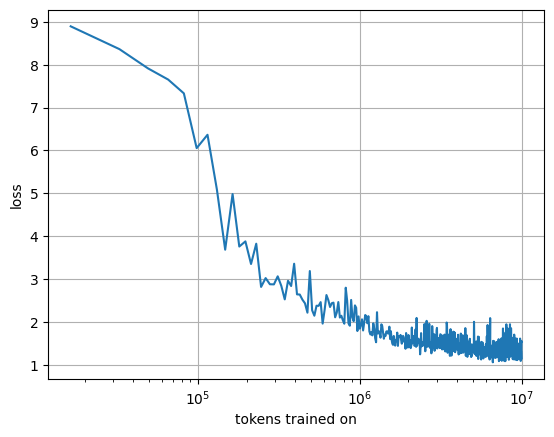

In [13]:
plt.plot(tokens_done_lst, losses)
plt.xscale("log")
plt.grid()
plt.ylabel("loss")
plt.xlabel("tokens trained on")

[0, 1, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 2, 1, 0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0]
['-0.3', '0.8', '1.5', '1.9', '-0.0', '0.8', '1.6', '2.0', '2.8', '2.5', '2.5', '2.2', '-0.1', '0.8', '1.8', '2.1', '2.5', '1.7', '-0.0', '0.9', '1.9', '2.2', '2.7', '3.4', '3.1', '2.8', '3.0', '2.7', '-0.0']


Text(0.5, 0, 'token id')

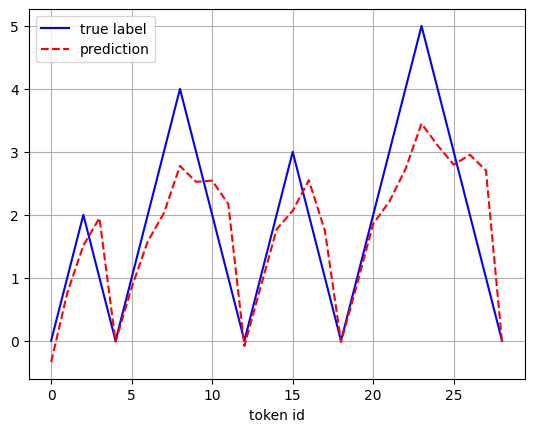

In [14]:
s = " sad sadness happy happiness "
# s = "Here is a long word: unhappy"
x = torch.from_numpy(np.array(encode(s)))
y = label_fn(encode(s))
preds = model(x)[0].detach()
print(y)
print([f"{p.item():.1f}" for p in preds])

plt.plot(y, "-b", label="true label")
plt.plot(preds, "--r", label="prediction")
plt.legend()
plt.grid()
plt.xlabel("token id")

**Task**: You can see that our model is not perfect at the task. Why do you think that is?

**Explanation:** The label at each position is the minimum of the distance to the previous space and the distance to the next space. This left-to-right RNN only observes what lies behind the current token. It never sees the upcoming boundary, so whenever the right-side space is closer than the left-side one, the target depends on future context the model does not have. The resulting predictions drift toward smoothed mid-range values, suppress peaks, and show bias at positions where the unseen future reverses which side is the minimum.

### Bidirectional model

Now, let's make a bidirectional RNN for this task. Complete the code below to make a bidirectional RNN.

In [15]:
class CharRegressionBiRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=2):
        """
        Character-level RNN for language modeling

        Args:
            vocab_size: Number of unique characters in vocabulary
            embed_dim: Dimension of character embeddings
            hidden_dim: Dimension of RNN hidden state
            num_layers: Number of stacked RNN layers
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Character embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # RNN layer (you can swap with LSTM or GRU)
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,  # Input shape: (batch, seq, feature)
            dropout=0,
            bidirectional=True
        )

        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x, hidden=None):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_length)
            hidden: Optional hidden state from previous step

        Returns:
            logits: Predicted logits of shape (batch_size, seq_length, vocab_size)
            hidden: Hidden state for next step
        """
        # Embed characters: (batch, seq) -> (batch, seq, embed_dim)
        embedded = self.embedding(x)

        # Pass through RNN: (batch, seq, embed_dim) -> (batch, seq, hidden_dim)
        rnn_out, hidden = self.rnn(embedded, hidden)

        # Project to vocabulary: (batch, seq, hidden_dim) -> (batch, seq, vocab_size)
        logits = self.fc(rnn_out)

        return logits, hidden

In [16]:
vocab_size = 65
embed_dim = 128
hidden_dim = 128
num_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

total_tokens = 10_000_000 # 1_000_000
batch_size = 64
block_size = 256
total_steps = total_tokens // (batch_size * block_size)
print(f"Total steps: {total_steps:,}")

model = CharRegressionBiRNN(vocab_size, embed_dim, hidden_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
model.train()

losses = []
tokens_done_lst = []
tokens_done = 0

pbar = tqdm.tqdm(range(total_steps))
for step in pbar:
  # Get batch
  x, y = get_batch('train', batch_size, block_size, device=device)
  optimizer.zero_grad()
  predictions, _ = model(x)
  predictions = predictions.reshape(-1)
  y = y.reshape(-1).float()

  # Compute loss and backprop
  loss = criterion(predictions, y)
  loss.backward()

  losses.append(loss.item())
  tokens_done += x.numel()
  tokens_done_lst.append(tokens_done)

  pbar.set_description(f"Loss: {loss.item():.4f}\tTokens: {tokens_done}\tProgress")

  # Gradient clipping (helpful for RNNs)
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

  optimizer.step()


Total steps: 610


Loss: 0.3927	Tokens: 9994240	Progress: 100%|██████████| 610/610 [03:18<00:00,  3.08it/s]


Text(0.5, 0, 'tokens trained on')

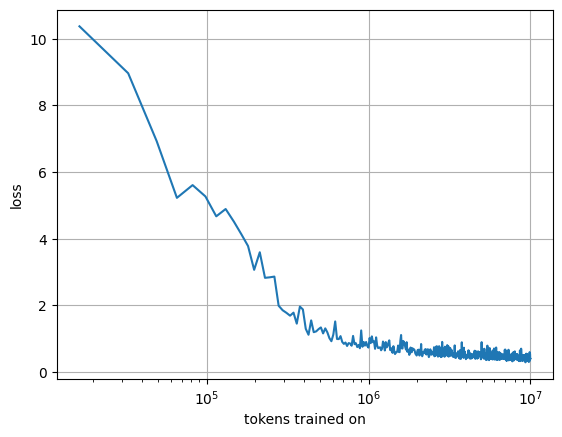

In [17]:
plt.plot(tokens_done_lst, losses)
plt.xscale("log")
plt.grid()
plt.ylabel("loss")
plt.xlabel("tokens trained on")

[0, 1, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 2, 1, 0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0]
['-0.4', '0.2', '1.2', '0.4', '-0.1', '1.0', '2.1', '3.7', '3.8', '3.1', '2.2', '1.3', '-0.0', '1.0', '2.2', '3.0', '2.2', '1.2', '-0.0', '1.3', '2.4', '3.3', '3.8', '4.2', '4.2', '3.3', '2.2', '1.3', '-0.3']


Text(0.5, 0, 'token id')

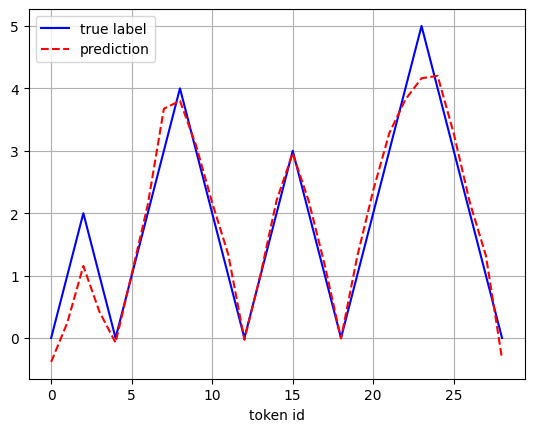

In [18]:
s = " sad sadness happy happiness "
x = torch.from_numpy(np.array(encode(s)))
y = label_fn(encode(s))
preds = model(x)[0].detach()
print(y)
print([f"{p.item():.1f}" for p in preds])

plt.plot(y, "-b", label="true label")
plt.plot(preds, "--r", label="prediction")
plt.legend()
plt.grid()
plt.xlabel("token id")

**Task:** Compare the loss values and the prediction quality to the one-directional model we trained above. Explain your observations.

**Explanation:** _add your explanation here_